In [1]:
# 8 worlds and 4 stages = 32 levels
WORLD = 1
STAGE = 1
LEVEL = f"{WORLD}-{STAGE}"
# 0 high, 1 low, 2 down, 3 lowest
QUALITY = 1
DEFAULT_GAME = f"SuperMarioBros-{LEVEL}-v{QUALITY}"
# Simplest list of actions
MY_ACTIONS = [["right"], ["right", "A"]]


# Important to set the 2 params below to affect time, each 50k steps takes
# Literature suggests  batches*each_batch_steps to exceed 10M to get reliably good Mario AI
# change to higher number for real run, 2 for test
batches = 22
# Change to 500k or more to expect see real impact
each_batch_steps = 500_000

# 1.IMPORTING OF PACKAGES

### Install necessary packages

In [1]:
%pip install stable-baselines3[extra] > /dev/null 2>&1
%pip install gym-super-mario-bros > /dev/null 2>&1
%pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

### Import necssary packages

In [2]:
import base64
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import numpy as np
import torch

# ----Game Env and Transform needed----
import gym
from gym.spaces import Box
import gym_super_mario_bros
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from gym.wrappers import FrameStack
from torchvision import transforms

# ----PPO RL Algorithm----
from stable_baselines3 import PPO

# 2.ALTERING OBESRVATION SPACE

In [3]:
# all changes executed below is based on gym module source code
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        my_transforms = transforms.Compose(
            [transforms.Resize(self.shape), transforms.Normalize(0, 255)]
        )
        observation = my_transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment, notice we limit the action spaces to MY_ACTIONS which only has 2 action
def build_env():
  env = gym_super_mario_bros.make(DEFAULT_GAME)
  env = SkipFrame(env, skip=4)
  env = GrayScaleObservation(env)
  env = ResizeObservation(env, shape=84)
  env = FrameStack(env, num_stack=4)
  env = JoypadSpace(env, MY_ACTIONS)
  return env

In [4]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

WHAT WE SEE


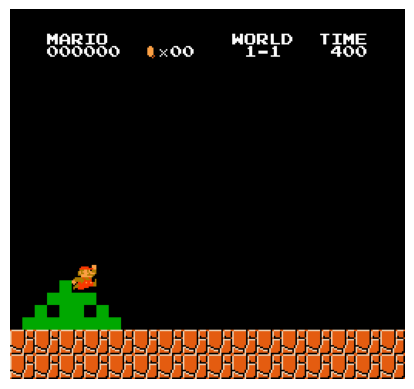

WHAT MODEL SEES


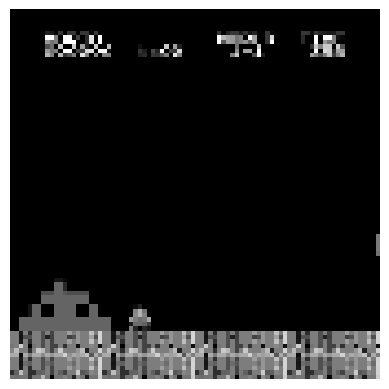

In [5]:
def see_world(test_env):
  obs = test_env.reset()
  for i in range(10):
      action = test_env.action_space.sample()
      obs, reward, done, info = test_env.step(action)

  from matplotlib import pyplot as plt
  if obs.shape[0] == 4:
    plt.imshow(obs[-1], cmap='gray')
    plt.axis('off')
  else:
    plt.imshow(obs)
    plt.axis('off')
  plt.show()
  del test_env
print("WHAT WE SEE")
see_world(gym_super_mario_bros.make(DEFAULT_GAME))
print("WHAT MODEL SEES")
see_world(build_env())

In [6]:
def save_gif(model, image_file, max_steps=2000):
  best_img = []
  all_rewards = []
  best_reward = 0
  for i in range(20): # choose 1 best out of 10
    env = build_env()
    obs = env.reset()
    im = Image.fromarray(env.render(mode = 'rgb_array'))
    images = [im]
    obs = env.reset()
    cur_best_reward = 0
    for i in range(1, max_steps + 1):
      # Reformat lazyframe to numpy for predict method
      b = torch.Tensor(4, 84, 84)
      torch.stack(obs._frames, out=b)
      action, _ = model.predict(b.numpy())
      print("action", action)
      # As of 09/2022, step func seems complain action as numpy scalar, so convert to int
      obs, reward, done, _ = env.step(action.tolist())
      cur_best_reward += reward
      # Render screen every 8/4 = 2 steps
      if i % 2 == 0:
        images.append(Image.fromarray(env.render(mode = 'rgb_array')))
      if done:
        break
    all_rewards.append(cur_best_reward)
    if cur_best_reward > best_reward or (cur_best_reward == best_reward and len(images) > len(best_img)):
      best_reward = cur_best_reward
      best_img = images
  best_img[0].save(image_file, save_all=True, append_images=best_img[1:], loop=0, duration=1)
  print("mean reward of 20 episodes", sum(all_rewards) / len(all_rewards), "\tlength", len(best_img))
  print("saved to", image_file)

# 3.TRAINING OF MODEL

In [ ]:
prefix = "ppo_cnn_"
CHECKPOINT_DIR= "./marioRL/models"
VID_DIR= "./marioRL/docs/videos"
LOG_DIR= "./logs/type2"

model = PPO('CnnPolicy', build_env(), verbose=0,tensorboard_log=LOG_DIR,learning_rate=linear_schedule(3e-4),ent_coef=0.01)
base_steps = 0
total_steps = base_steps
for i in range(1, 1 + batches):
  obs = model.env.reset()
  model.learn(total_timesteps=each_batch_steps)
  total_steps += each_batch_steps
  if each_batch_steps > 50000:  # only save model if the batch step > 50k
    model.save(os.path.join(CHECKPOINT_DIR,f"model_{total_steps}"))

# 4.TESTING THE MODEL

In [15]:
total_steps = each_batch_steps
for i in range(1,1+batches):
    model.load(f"./marioRL/models/model_{total_steps}.zip")
    save_gif(model, os.path.join(VID_DIR, f"model_{total_steps}"+".gif"))
    total_steps = total_steps + each_batch_steps

mean reward of 20 episodes 726.15 	length 222
saved to ./marioRL/docs/videos\model_50000.gif
mean reward of 20 episodes 690.75 	length 237
saved to ./marioRL/docs/videos\model_100000.gif
mean reward of 20 episodes 731.1 	length 396
saved to ./marioRL/docs/videos\model_150000.gif
mean reward of 20 episodes 640.6 	length 175
saved to ./marioRL/docs/videos\model_200000.gif
mean reward of 20 episodes 669.55 	length 134
saved to ./marioRL/docs/videos\model_250000.gif
mean reward of 20 episodes 624.35 	length 155
saved to ./marioRL/docs/videos\model_300000.gif
mean reward of 20 episodes 673.8 	length 207
saved to ./marioRL/docs/videos\model_350000.gif
mean reward of 20 episodes 698.15 	length 126
saved to ./marioRL/docs/videos\model_400000.gif
mean reward of 20 episodes 577.9 	length 148
saved to ./marioRL/docs/videos\model_450000.gif
mean reward of 20 episodes 704.4 	length 223
saved to ./marioRL/docs/videos\model_500000.gif
mean reward of 20 episodes 550.15 	length 114
saved to ./marioRL/d

In [15]:
while True:
    env = build_env()
    obs = env.reset()
    model.load(f"./marioRL/models/model_150000.zip")
    for i in range(1, 2000 + 1):
        # Reformat lazyframe to numpy for predict method
        b = torch.Tensor(4, 84, 84)
        torch.stack(obs._frames, out=b)
        action, _ = model.predict(b.numpy())
        obs, reward, done, _ = env.step(action.tolist())
        env.render()
        if done:
            env.close()
            break

KeyboardInterrupt: 

In [16]:
env.close()

# 5.GETTING OUTPUTS

In [21]:
total_steps = each_batch_steps
for i in range(1,1+batches):
    embed.embed_file(f"./marioRL/docs/videos/model_{total_steps}.gif")
    total_steps = total_steps + each_batch_steps